In [24]:
import numpy as np
import pandas as pd
import treecorr
from matplotlib import pyplot as plt

In [25]:
fold_path = "./../out/20230112_mike_paper/"

rmin = 0.5
rmax = 20
nr = 10

narrow = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.0, max_u=1, nubins=20,
              min_v=0.0, max_v=0.1, nvbins=1, verbose=2, output_dots=True)
wide = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
            min_u=0.9, max_u=1, nubins=1,
            min_v=0.0, max_v=0.8, nvbins=20, verbose=2, output_dots=True)
wider = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
             min_u=0.9, max_u=1, nubins=1,
             min_v=0.8, max_v=0.95, nvbins=20, verbose=2, output_dots=True)
widest = dict(min_sep=rmin, max_sep=rmax, sep_units='arcmin', nbins=nr,
              min_u=0.9, max_u=1, nubins=1,
              min_v=0.95, max_v=1.0, nvbins=20, verbose=2, output_dots=True)

print("narrow")
ggg1 = treecorr.GGGCorrelation(narrow)
ggg1.read(fold_path + 'narrow.hdf')

print("wide")
ggg2 = treecorr.GGGCorrelation(wide)
ggg2.read(fold_path + 'wide.hdf')

print("wider")
ggg3 = treecorr.GGGCorrelation(wider)
ggg3.read(fold_path + 'wider.hdf')

print("widest")
ggg4 = treecorr.GGGCorrelation(widest)
ggg4.read(fold_path + 'widest.hdf')

narrow
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 20, min,max = 0..1, bin_size = 0.05
v: nbins = 1, min,max = 0..0.1, bin_size = 0.1
Reading GGG correlations from ./../out/20230112_mike_paper/narrow.hdf
   file_type assumed to be HDF from the file name.
wide
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0..0.8, bin_size = 0.04
Reading GGG correlations from ./../out/20230112_mike_paper/wide.hdf
   file_type assumed to be HDF from the file name.
wider
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, min,max = 0.8..0.95, bin_size = 0.0075
Reading GGG correlations from ./../out/20230112_mike_paper/wider.hdf
   file_type assumed to be HDF from the file name.
widest
r: nbins = 10, min,max sep = 0.5..20 arcmin, bin_size = 0.368888
u: nbins = 1, min,max = 0.9..1, bin_size = 0.1
v: nbins = 20, mi

In [26]:
def g_ttt_func(ggg):
    return -0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).real

def var_ttt_func(ggg):
    return 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

In [27]:
def get_gamma_func(g_func, var_func):
    all_g_ttt = []
    all_sig_ttt = []
    all_meanr = []
    all_phi = []

    for ggg in [ggg1, ggg2, ggg3, ggg4]:

        g_ttt = g_func(ggg)
        var_ttt = var_ttt_func(ggg)

        _nr, nu, nv = g_ttt.shape
        assert _nr == nr
        assert nv % 2 == 0
        nv //= 2
        assert nu == 1 or nv == 1

        d1 = ggg.meand1
        d2 = ggg.meand2
        d3 = ggg.meand3
        if nu == 1:
            # if nu==1, then u=1, so d2 = d3, and phi is between d2 and d3
            phi = np.arccos( (d2**2 + d3**2 - d1**2) / (2*d2*d3) )
            meanr = np.array([np.mean([d2[ir], d3[ir]]) for ir in range(nr)])
        else:
            # if nv==1, then v=0, so d1 = d2, and phi is between d1 and d2
            phi = np.arccos( (d1**2 + d2**2 - d3**2) / (2*d1*d2) )
            meanr = np.array([np.mean([d1[ir], d2[ir]]) for ir in range(nr)])
        phi *= 180/np.pi

        # We don't care about v>0 vs v<0, so combine them.
        phi = (phi[:,:,nv-1::-1] + phi[:,:,nv:]) / 2
        g_ttt = (g_ttt[:,:,nv-1::-1] + g_ttt[:,:,nv:]) / 2
        var_ttt = (var_ttt[:,:,nv-1::-1] + var_ttt[:,:,nv:]) / 4
        sig_ttt = var_ttt**0.5

        # print('shapes:')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)
        # print('meanr: ',meanr.shape)

        # print('meanr =  ',meanr)

        if nu == 1:
            phi = phi[:,0,:]
            g_ttt = g_ttt[:,0,:]
            sig_ttt = sig_ttt[:,0,:]
        else:
            phi = phi[:,:,0]
            g_ttt = g_ttt[:,:,0]
            sig_ttt = sig_ttt[:,:,0]

        # print('shapes ->')
        # print('phi: ',phi.shape)
        # print('g_ttt: ',g_ttt.shape)
        # print('sig_ttt: ',sig_ttt.shape)

        all_phi.append(phi)
        all_g_ttt.append(g_ttt)
        all_sig_ttt.append(sig_ttt)
        all_meanr.append(meanr)

    phi = np.concatenate(all_phi, axis=1)
    g_ttt = np.concatenate(all_g_ttt, axis=1)
    sig_ttt = np.concatenate(all_sig_ttt, axis=1)
    meanr = np.concatenate(all_meanr, axis=0)
    
    return phi, g_ttt, sig_ttt, meanr

In [28]:
phi, g_ttt, sig_ttt, meanr = get_gamma_func(g_ttt_func, var_ttt_func)

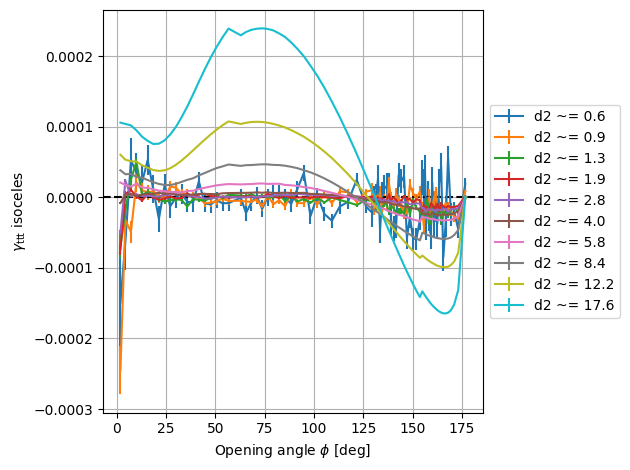

In [29]:
fig, ax = plt.subplots()

lines = []
for ir in range(nr):
    line = ax.errorbar(phi[ir], g_ttt[ir], sig_ttt[ir])
    lines.append((line, 'd2 ~= %.1f'%meanr[ir]))

ax.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r'Opening angle $\phi$ [deg]')
ax.set_ylabel(r'$\gamma_{\rm ttt}$ isoceles')

fig.set_tight_layout(True)
ax.grid()
ax.axhline(y=0, ls="--", color="black")
plt.show()
plt.close()

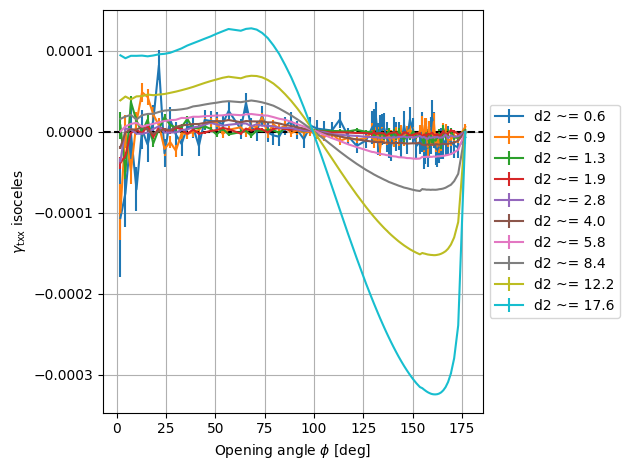

In [30]:
def g_txx_func(ggg):
    return -0.25 * (- ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).real

def var_txx_func(ggg):
    return 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

phi, g_txx, sig_txx, meanr = get_gamma_func(g_txx_func, var_txx_func)

fig, ax = plt.subplots()

lines = []
for ir in range(nr):
    line = ax.errorbar(phi[ir], g_txx[ir], sig_txx[ir])
    lines.append((line, 'd2 ~= %.1f'%meanr[ir]))

ax.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r'Opening angle $\phi$ [deg]')
ax.set_ylabel(r'$\gamma_{\rm txx}$ isoceles')

fig.set_tight_layout(True)
ax.grid()
ax.axhline(y=0, ls="--", color="black")
plt.show()
plt.close()

In [31]:
g_ttt_func = lambda ggg: -0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_txx_func = lambda ggg: -0.25 * (- ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).real
g_xtx_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).real
g_xxt_func = lambda ggg: -0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).real
g_ttx_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 + ggg.gam2 - ggg.gam3).imag
g_txt_func = lambda ggg: 0.25 * (ggg.gam0 + ggg.gam1 - ggg.gam2 + ggg.gam3).imag
g_xtt_func = lambda ggg: 0.25 * (ggg.gam0 - ggg.gam1 + ggg.gam2 + ggg.gam3).imag
g_xxx_func = lambda ggg: 0.25 * (- ggg.gam0 + ggg.gam1 + ggg.gam2 + ggg.gam3).imag

def var_func(ggg):
    return 0.25**2 * (ggg.vargam0 + ggg.vargam1 + ggg.vargam2 + ggg.vargam3)

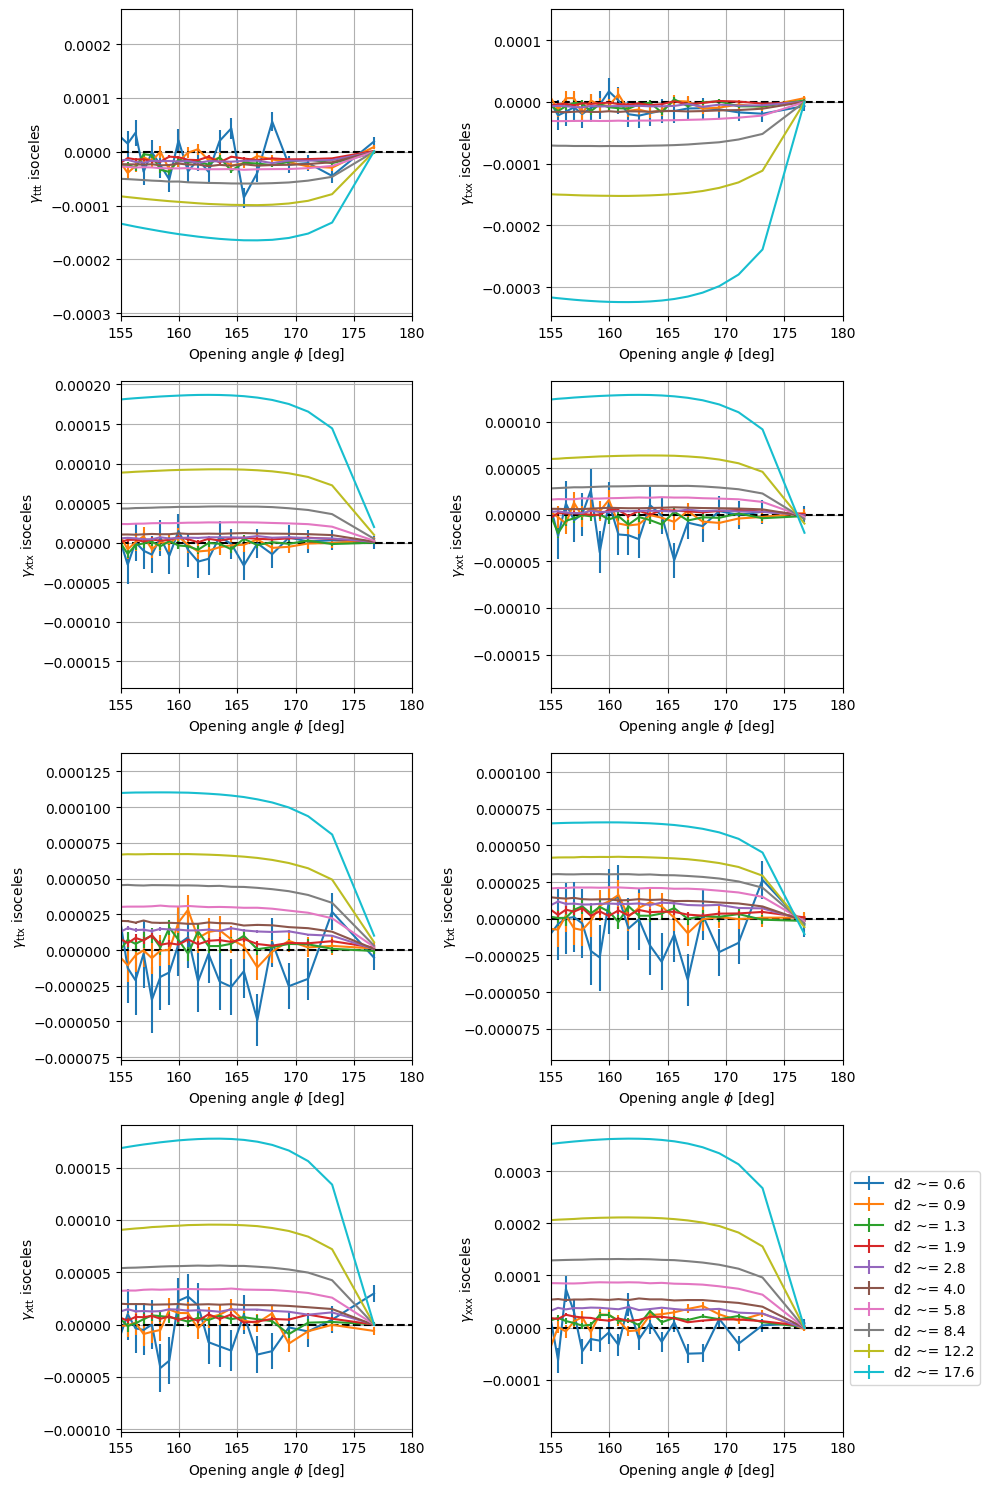

In [35]:
g_funcs = [g_ttt_func, g_txx_func, g_xtx_func, g_xxt_func, g_ttx_func, g_txt_func, g_xtt_func, g_xxx_func]
labels = ["{\\rm ttt}", "{\\rm txx}", "{\\rm xtx}", "{\\rm xxt}", "{\\rm ttx}", "{\\rm txt}", "{\\rm xtt}", "{\\rm xxx}"]

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for label, g_func, ax in zip(labels, g_funcs, axs.ravel()):
    
    phi, g_txx, sig_txx, meanr = get_gamma_func(g_func, var_func)
    lines = []
    for ir in range(nr):
        line = ax.errorbar(phi[ir], g_txx[ir], sig_txx[ir])
        lines.append((line, 'd2 ~= %.1f'%meanr[ir]))
    ax.set_xlabel(r'Opening angle $\phi$ [deg]')
    ax.set_ylabel(r'$\gamma_{}$ isoceles'.format(label))
    ax.set_xlim([155, 180])
    fig.set_tight_layout(True)
    ax.grid()
    ax.axhline(y=0, ls="--", color="black")
plt.legend(*(list(zip(*lines))), loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("./../figs/other3pt/20230112_mike_paper.pdf", dpi=300)
plt.show()
plt.close()

# ```threepoint``` Model

In [15]:
g_ttt_func = lambda d2data: -0.25 * (d2data["Rg0"] + d2data["Rg1"] + d2data["Rg2"] + d2data["Rg3"])
g_txx_func = lambda d2data: -0.25 * (- d2data["Rg0"] - d2data["Rg1"] + d2data["Rg2"] + d2data["Rg3"])
g_xtx_func = lambda d2data: -0.25 * (- d2data["Rg0"] + d2data["Rg1"] - d2data["Rg2"] + d2data["Rg3"])
g_xxt_func = lambda d2data: -0.25 * (- d2data["Rg0"] + d2data["Rg1"] + d2data["Rg2"] - d2data["Rg3"])
g_ttx_func = lambda d2data: 0.25 * (d2data["Ig0"] + d2data["Ig1"] + d2data["Ig2"] - d2data["Ig3"])
g_txt_func = lambda d2data: 0.25 * (d2data["Ig0"] + d2data["Ig1"] - d2data["Ig2"] + d2data["Ig3"])
g_xtt_func = lambda d2data: 0.25 * (d2data["Ig0"] - d2data["Ig1"] + d2data["Ig2"] + d2data["Ig3"])
g_xxx_func = lambda d2data: 0.25 * (- d2data["Ig0"] + d2data["Ig1"] + d2data["Ig2"] + d2data["Ig3"])

In [16]:
file_path = './Gamma_small_scales_sompz4_full.dat'

data = pd.read_csv(file_path, delimiter=' ', \
                   names=['Rg0', 'Ig0', 'Rg1', 'Ig1', 'Rg2', 'Ig2', 'Rg3', 'Ig3', 'd2', 'u', 'v'])

print(data.head())

            Rg0           Ig0           Rg1           Ig1           Rg2  \
0 -2.022310e-07 -4.561160e-14 -1.022220e-06  1.661710e-07 -1.022260e-06   
1 -2.161530e-07 -5.218580e-15 -7.513280e-07  4.058890e-07 -7.513280e-07   
2 -2.317540e-07  3.259590e-20 -4.486990e-07  5.133590e-07 -4.486980e-07   
3 -2.485230e-07  7.668510e-16 -1.666870e-07  5.006600e-07 -1.666870e-07   
4 -2.661780e-07 -1.556740e-14  5.832020e-08  3.951180e-07  5.832020e-08   

            Ig2           Rg3           Ig3        d2      u    v  
0 -1.661770e-07 -6.252620e-07 -7.258730e-14  0.629463  0.025  0.0  
1 -4.058890e-07 -6.375650e-07 -6.585270e-15  0.629463  0.075  0.0  
2 -5.133590e-07 -6.503860e-07 -2.499720e-15  0.629463  0.125  0.0  
3 -5.006600e-07 -6.632530e-07  1.436520e-14  0.629463  0.175  0.0  
4 -3.951180e-07 -6.759920e-07 -4.550880e-14  0.629463  0.225  0.0  


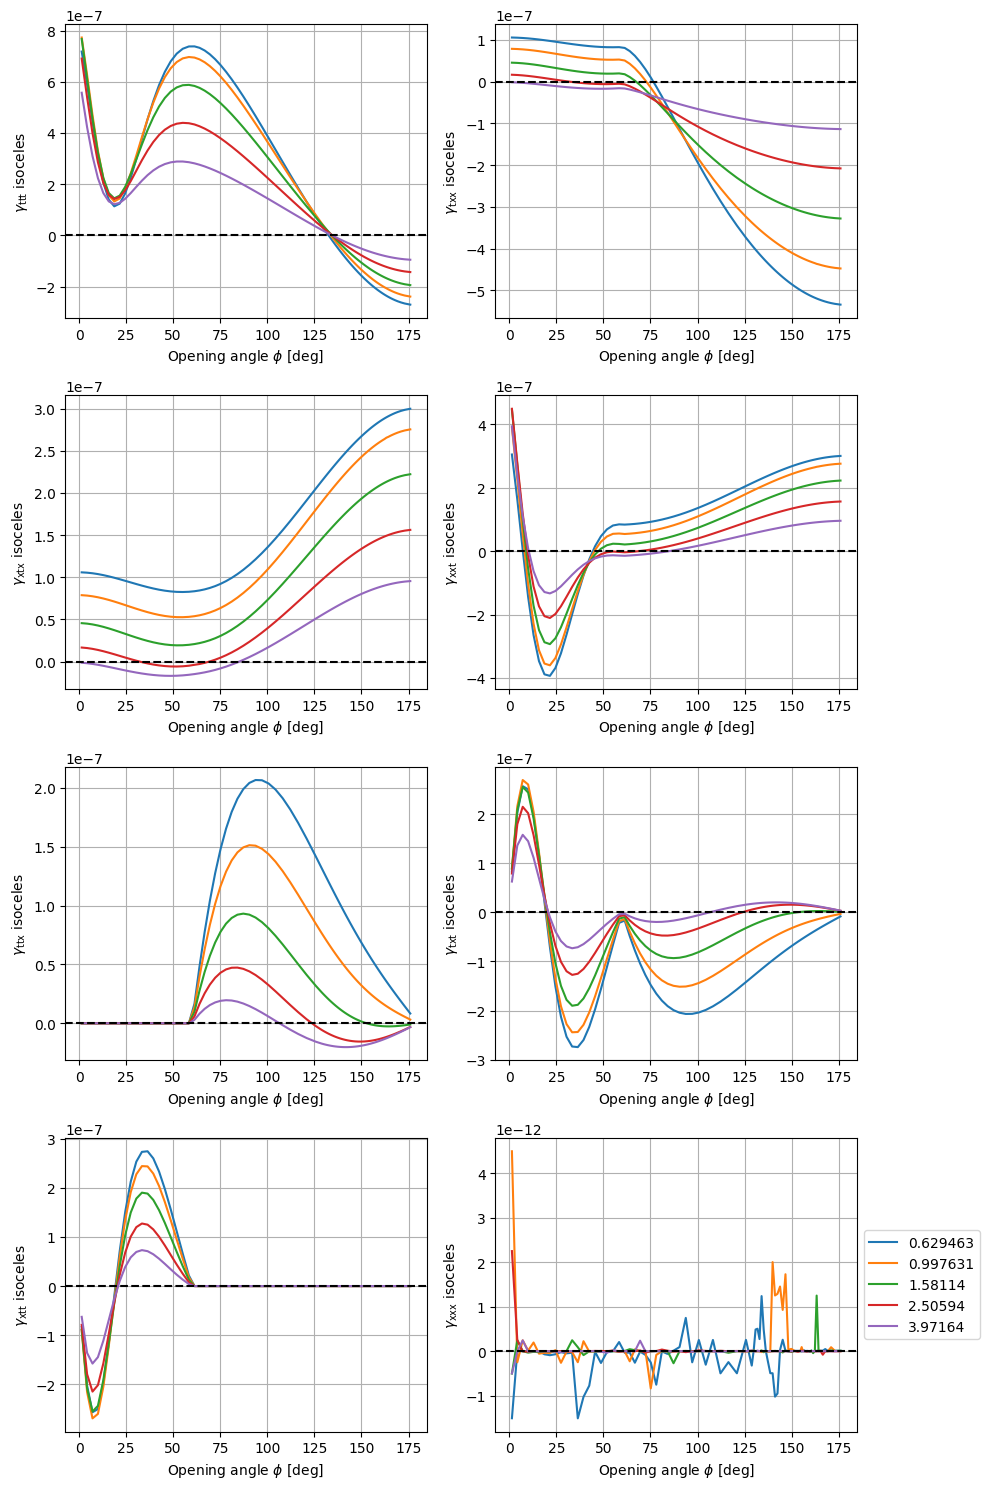

In [23]:
g_funcs = [g_ttt_func, g_txx_func, g_xtx_func, g_xxt_func, g_ttx_func, g_txt_func, g_xtt_func, g_xxx_func]
labels = ["{\\rm ttt}", "{\\rm txx}", "{\\rm xtx}", "{\\rm xxt}", "{\\rm ttx}", "{\\rm txt}", "{\\rm xtt}", "{\\rm xxx}"]

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for label, g_func, ax in zip(labels, g_funcs, axs.ravel()):
    
    for ind, d2 in enumerate(d2vals):
        d2data = data[data["d2"] == d2]
        g_ttt[ind] = g_func(d2data)
        phi[ind] = np.array(np.rad2deg(np.arccos(1 - (d2data["u"] + d2data["v"]) ** 2 / 2)))
        ax.plot(phi[ind], g_ttt[ind], label = d2)

    ax.set_xlabel(r'Opening angle $\phi$ [deg]')
    ax.set_ylabel(r'$\gamma_{}$ isoceles'.format(label))
    # ax.set_xlim([120, 180])

    fig.set_tight_layout(True)
    ax.grid()
    ax.axhline(y=0, ls="--", color="black")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("./../figs/other3pt/20230201_threepoint.pdf", dpi=300)
plt.show()
plt.close()